# Noise Removal using Convolutional Autoencoder <br>
The conventional technique of noise removal is not successfull in all the cases, Hence a convolutional autoencoder is used for the denoising purpose of the input audio file.
    

## INPUT TO THE AUTOENCODER <br>
The inputs to the autoencoder is going to be from the data base that is provided in (Link).It is a large dataset of around 5GB in size that contains short recordings of the human commands or speech both with and without noise. The noise included in the dataset is from the various environments such as the living room ,cafeteria, bus and market. It also includes the message that is spoken by the person in terms of the text file hence we will be able to use it as the reference text to compare it against the results from the ensemble algorithm.<br>
### FORMATS OF INPUT<br>
The available formats that represent the audio file and are available to be used as an input to auto-encoders are considered below.(It is necessary to be perfectly recreate the audio signal from the representation as the Speech To Text engines are only fed with the audio inputs).


In [47]:
# importing the libraries
"""
@author: shan #300035774         
"""
import pylab
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import math
import librosa
import librosa.display
import tensorflow as tf
% matplotlib inline

The inputs that are considered in this case are STFT,MFCC,FFT and Filter banks of the original signals.

In [33]:
# SHORT TIME FOURIER TRANSFORM
def stft(x, fs, frame_length, frame_step):
    #hamming window
    w = scipy.hanning(frame_length)
    X = scipy.array([scipy.fft(w * x[i:i + frame_length])
                     for i in range(0, len(x) - frame_length, frame_step)])
    return X
# INVERSE SHORT TIME FOURIER TRANSFORM

def istft(X, fs, T, frame_length,frame_step):
    x = scipy.zeros(T * fs)
    for n, i in enumerate(range(0, len(x) - frame_length, int(frame_step))):
        x[i:i + frame_length] += scipy.real(scipy.ifft(X[n]))
    return x
# FAST FOURIER TRANSFORM

def fft_t(signal, t):
    N = signal.shape[0]
    FFT = abs(scipy.fft(signal))
    FFT_side = FFT[range(int(N / 2))]  # one side FFT range
    freqs = scipy.fftpack.fftfreq(signal.size, t[1] - t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(int(N / 2))]  # one side frequency range
    fft_freqs_side = np.array(freqs_side)
    return FFT, FFT_side, fft_freqs, fft_freqs_side
# FILTER BANKS
def f_bank(frames,frame_length,sample_rate):
    nfilt = 40
    low_freq_mel = 0
    NFFT = 512
    # Hamming window
    frames *= np.hamming(frame_length)
    # Fourier-Transform and Power Spectrum

    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))  # Magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

    # Filter Banks
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)
    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right
        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks) # dB
    return filter_banks
# PLOTTING FUNCTIONS
def plot_im(x_data,ext=None,x_lim=None,y_lim=None):
    pylab.imshow(x_data, origin='lower', aspect='auto',
             interpolation='nearest', extent=ext)
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    pylab.xlabel('Time')
    pylab.ylabel('Frequency')
    pylab.show()
def plot(t,sig,x_axis='time',y_axis='Amplitude'):
    plt.plot(t, signal)  # plotting the signal
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
def plot_comp(x,y):
    plt.plot(x,'g')
    plt.plot(y,'r')
    plt.show()
def padding(arr,size=(1200,1200)):
    inser = arr
    zeros = np.zeros(1440000,dtype=complex).reshape( size )
    zeros[:inser.shape[0], :inser.shape[1]] = inser
    return zeros

In [31]:
sample_rate, signal = scipy.io.wavfile.read("training_data/tony/sample-000000_2.wav")
#signal,sample_rate= librosa.load("training_data/tony/sample-000000_1.wav")
print ("Frequency sampling", sample_rate)
N = signal.shape[0]
print ("Complete Samplings N", N)
secs = N / float(sample_rate)
print ("secs", secs)
signal = signal[0:int(secs * sample_rate)]  # the total time of the signal
Ts = 1.0 / sample_rate  # sampling interval in time
print ("Timestep between samples Ts", Ts)
T = int(secs)
# The x axis for time
t = scipy.arange(0, secs, Ts)



Frequency sampling 44100
Complete Samplings N 441000
secs 10.0
Timestep between samples Ts 2.2675736961451248e-05


In [34]:
# emphasis is applied in time domain
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
emphasized_signal = signal


# Framing
frame_size = 0.050
frame_stride = 0.025
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1


# padding the signal to make equal no of frames

pad_signal_length = num_frames * frame_step + frame_length
z = np.zeros((pad_signal_length - signal_length))
pad_signal = np.append(emphasized_signal, z)  # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal
indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]



# compute filter banks
filter_banks=f_bank(frames,frame_length,sample_rate)

# comput the STFT
X = stft(pad_signal, sample_rate, frame_length, frame_step)
X_plt=np.ones(X.shape)
X_plt = 20 * np.log10(X) # dB
D = librosa.stft(emphasized_signal)
# Compute the ISTFT.
xhat = istft(X, sample_rate, T, frame_length,frame_step)
yhat=librosa.istft(filter_banks)
y_hat = librosa.istft(D)
# compute the FFT
FFT, FFT_side, freqs, freqs_side = fft_t(signal, t)





The FFT of the corresponding audio signal


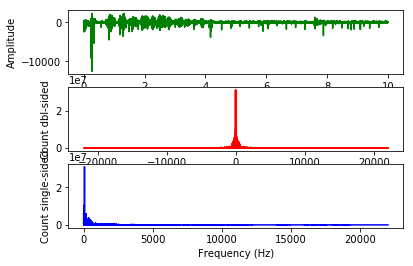

In [38]:
print('The FFT of the corresponding audio signal')
# plotting of the FFT signal
plt.subplot(311)
p1 = plt.plot(t, signal, "g")  # plotting the signal
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.subplot(312)
p2 = plt.plot(freqs, FFT, "r")  # plotting the complete fft spectrum
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count dbl-sided')
plt.subplot(313)
p3 = plt.plot(freqs_side, abs(FFT_side), "b")  # plotting the positive fft spectrum
plt.xlabel('Frequency (Hz)')
plt.ylabel('Count single-sided')
plt.show()



The F_bank of the corresponding audio signal is


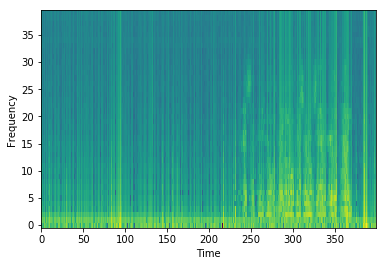

The STFT of the corresponding audio signal using librosa


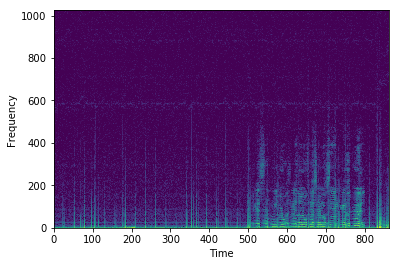


 The STFT of the corresponding audio signal is


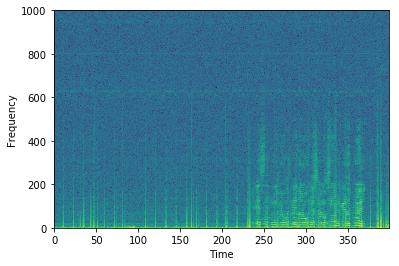

In [37]:
# plotting all the possible inputs
print('The F_bank of the corresponding audio signal is')
plot_im(np.rot90(filter_banks,3))
print('The STFT of the corresponding audio signal using librosa')
plot_im(np.fliplr(librosa.amplitude_to_db(D,ref=np.max)))
print('\n The STFT of the corresponding audio signal is' )
plot_im(np.rot90(np.abs(X_plt),3),y_lim=(0,1000))


The reconstruction comparision between the original and the Invserse STFT using Librosa


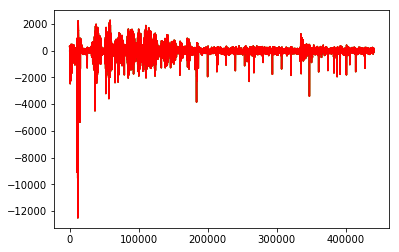

The reconstruction comparision between the original and the Invserse STFT


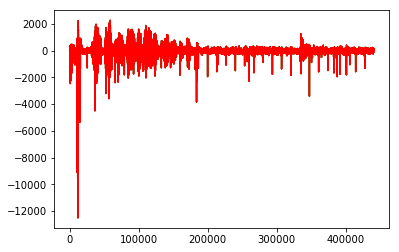

The reconstruction comparision between the original and the F_banks


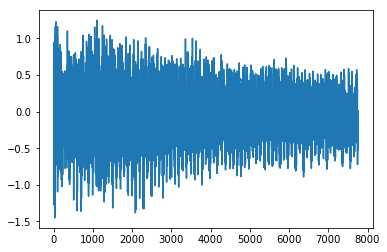

In [41]:
# Reconstruction of the original signal 
# checking the signal
print('The reconstruction comparision between the original and the Invserse STFT using Librosa')
plot_comp(y_hat,emphasized_signal)
print('The reconstruction comparision between the original and the Invserse STFT')
plot_comp(xhat,emphasized_signal)
print('The reconstruction comparision between the original and the F_banks')
plt.plot(yhat)
plt.show()
#plot_comp(yhat,emphasized_signal)
# The signals are perfectly overlapping so that we cannot see the original signal
plt.plot(emphasized_signal)

As the signals reconstructed are perfectly in the case of STFT, and the reconstruction of the signal in the case of FFT , Filterbanks and the MFCC is not either possible or difficult, we can go for the STFT of the audio which is given as a the spectrogram for the convolutional Neural Network.

## NETWORK ARCHITECTURE<br>

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A architecture of the network is given below.
<img src='assets/convolutional_autoencoder.png' width=500px><br>
Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. To denoise images quite successfully just by training the network on noisy images ,I create the noisy images by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. Now the noisy images are used as input and the original, clean images as targets.



Just for the better understanding of the network i have built a convolutional autoencoder to denoise the MNIST dataset that is added with the gaussian noise and then normalised.

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(784,)


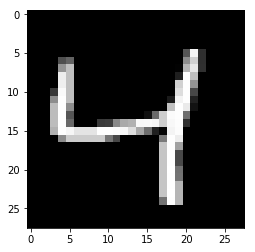

In [45]:
# importing the data from tensorflow examples
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)
img = mnist.train.images[2]
print(img.shape)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [48]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')
# The loss function used is cross_entropy
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [ ]:
with tf.Session() as sess:
    epochs = 100
    batch_size = 200
    # Set's how much noise we're adding to the MNIST images
    noise_factor = 0.5
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            # Get images from the batch
            imgs = batch[0].reshape((-1, 28, 28, 1))
            # Add random noise to the input images
            noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
            # Clip the images to be between 0 and 1
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)
            # Noisy images as inputs, original images as targets
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})
           # print("Epoch: {}/{}...".format(e+1, epochs),
              #"Training loss: {:.4f}".format(batch_cost))

### Checking out the performance

As it took very long for me to run the epochs i am not running the above but only including the result that is obtained from the same 
Here I'm adding noise to the test images and passing them through the autoencoder. Due to the computational limitation, i have gone easy on the number of epochs but even for that it does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)

<img src='assets/denoising.png' width=500px><br>

## Implementation of the autoencoder
Now that i have taken spectrogram(STFT) of the dataset all the 5 GB data whose sample is shown below, We can train the autoencoder to reduce the noise that are introduced by the various scenarios that we have already discussed before.<br>
The spectrogram of the noisy signal is given by <br>

<img src="assets/p226_001_noisy.wav.png" height="900" width="5000">
<img src="assets/p226_002_noisy.wav.png" height="900" width="5000">
The spectrogram of the clean signal is given by <br>
<img src="assets/p226_001.wav.png" height="90o" width="5000">
<img src="assets/p226_002.wav.png" height="90o" width="5000">





Given that we have the spectrogram for the input speech that is of various length we pad the matrix to be of the same fixed length by the zero padding.(padding function already created)

In [ ]:
inputs_ = tf.placeholder(tf.float32, (None, 1200, 1200, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 1200, 1200, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 64, (250,250), padding='same', activation=tf.nn.relu)
# Now 1200x1200x64
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 600x600x64
conv2 = tf.layers.conv2d(maxpool1, 32, (250,250), padding='same', activation=tf.nn.relu)
# Now 600x600x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 300x300x32
conv3 = tf.layers.conv2d(maxpool2, 16, (250,250), padding='same', activation=tf.nn.relu)
# Now 300x300x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 150x150x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (150,150))
# Now 150x150x16
conv4 = tf.layers.conv2d(upsample1, 16, (250,250), padding='same', activation=tf.nn.relu)
# Now 150x150x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (300,300))
# Now 300x300x16
conv5 = tf.layers.conv2d(upsample2, 32, (250,250), padding='same', activation=tf.nn.relu)
# Now 300x300x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (600,600))
# Now 600x600x32
conv6 = tf.layers.conv2d(upsample3, 32, (250,250), padding='same', activation=tf.nn.relu)
# Now 600x600x32
upsample4 = tf.image.resize_nearest_neighbor(conv6, (1200,1200))
# Now 1200x1200x32
conv7 = tf.layers.conv2d(upsample4, 64, (250,250), padding='same', activation=tf.nn.relu)
# Now 1200x1200x64

logits = tf.layers.conv2d(conv7, 1, (250,250), padding='same', activation=None)
#Now 1200*1200*1

decoded = tf.nn.sigmoid(logits, name='decoded')
# The loss function used is cross_entropy
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [ ]:
# COMMENTS AND SUGGESTIONS FOR THE CONVOLUTIONAL DECODER MODEL ARE WELCOME